In [66]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import ast
from collections import Counter
from wordcloud import WordCloud
from itertools import chain
from transformers import pipeline

from collections import defaultdict

In [67]:
# Load graph
with open("data/Musicians_graph.pkl", "rb") as f:
    MusiciansG = pickle.load(f)

with open("data/groups_graph.pkl", "rb") as f:
    GroupsG = pickle.load(f)

### Groups Network

In [68]:
# Remove isolates
GroupsG.remove_nodes_from(list(nx.isolates(GroupsG)))
len(GroupsG.nodes)

398

In [69]:
def is_strong_community(G, community):
    for node in community:
        internal = sum(1 for neighbor in G.neighbors(node) if neighbor in community)
        external = sum(1 for neighbor in G.neighbors(node) if neighbor not in community)
        if internal <= external:
            return False
    return True

def is_weak_community(G, community):
    internal_total = 0
    external_total = 0
    for node in community:
        internal_total += sum(1 for neighbor in G.neighbors(node) if neighbor in community)
        external_total += sum(1 for neighbor in G.neighbors(node) if neighbor not in community)
    return internal_total > external_total

In [70]:
#degree of groups
dict_degree = dict(sorted([[band, degree] for band, degree in dict(GroupsG.degree()).items()], key=lambda x: int(x[1]), reverse=True))

### Partitioning + Plot

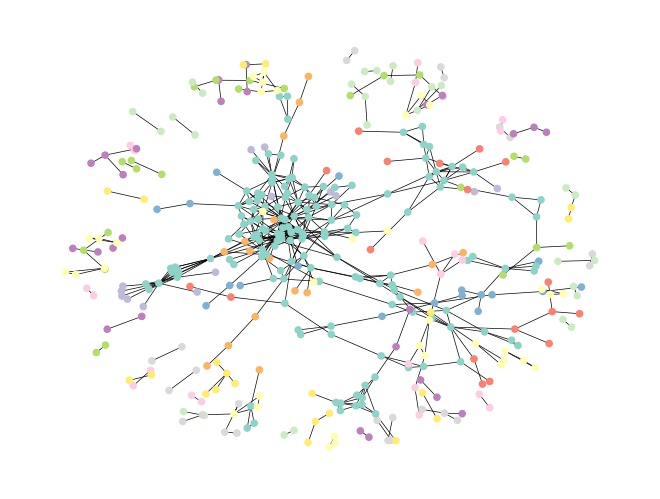

In [71]:
#Get all biconnected components as sets of nodes
bicomponents = list(nx.biconnected_components(GroupsG))

#Sort components by decreasing size
bicomponents.sort(key=lambda c: len(c), reverse = True)

#Assign nodes uniquely to clusters
node_to_cluster = {}
assigned_nodes = set()
cluster_id = 1

for component in bicomponents:
    # Get only the unassigned nodes in this component
    unassigned = component - assigned_nodes
    if unassigned:
        for node in unassigned:
            node_to_cluster[node] = cluster_id
        assigned_nodes.update(unassigned)
        cluster_id += 1

# Draw with community colors
G = GroupsG
pos = nx.spring_layout(G, k = 0.12, seed= 43)
colors = [node_to_cluster[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, width = 0.5, node_size = 20, cmap=plt.cm.Set3)
plt.show()

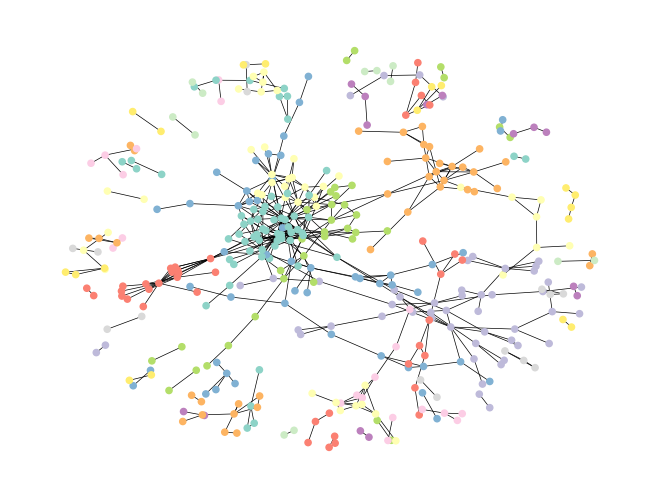

In [72]:
G = GroupsG
from community import community_louvain
partition = community_louvain.best_partition(G)

# Draw with community colors
pos = nx.spring_layout(G, k = 0.12, seed= 43)
colors = [partition[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, width = 0.5, node_size = 20, cmap=plt.cm.Set3)
plt.show()

#### Computing modularity

In [73]:
label_to_nodes = defaultdict(set)
for node, label in node_to_cluster.items():
    label_to_nodes[label].add(node)

# Convert the values to a list of sets
communities1 = list(label_to_nodes.values())


label_to_nodes = defaultdict(set)
for node, label in partition.items():
    label_to_nodes[label].add(node)

# Convert the values to a list of sets
communities2 = list(label_to_nodes.values())

In [74]:
modularity1 = nx.algorithms.community.modularity(GroupsG, communities1)
modularity2 = nx.algorithms.community.modularity(GroupsG, communities2)
print(f"modularity of partition 1: {round(modularity1,2)}")
print(f"modularity of partition 2: {round(modularity2,2)}")

modularity of partition 1: 0.54
modularity of partition 2: 0.8


### Plotting partitions size

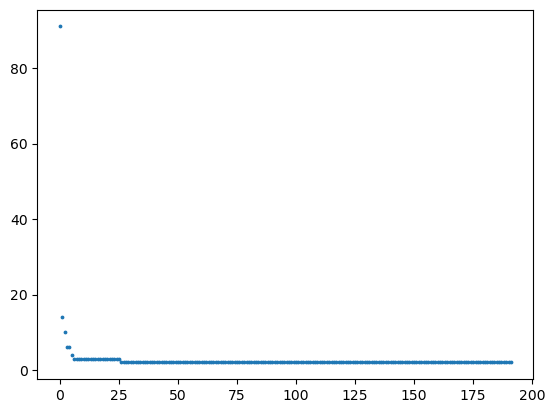

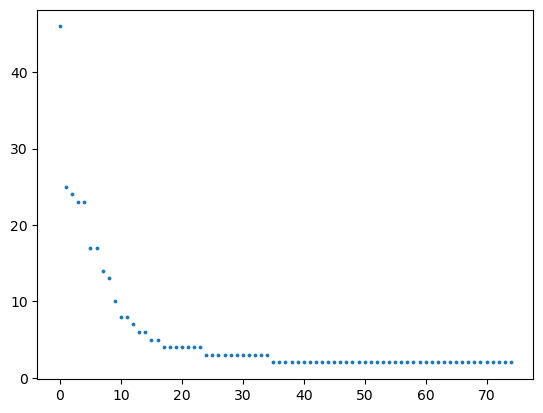

In [75]:
plt.scatter(list(range(len(bicomponents))), [len(c) for c in bicomponents], s = 3)
plt.show()
plt.scatter(list(range(len(Counter(partition.values())))), [x[1] for x in sorted(Counter(partition.values()).items(), key= lambda x: x[1], reverse=True)], s = 3)

In [76]:
articulation_points = list(nx.articulation_points(G))
print("Articulation (overlap) nodes:", articulation_points)

Articulation (overlap) nodes: ['Big Fat Snake', 'Dig og mig og solskin', 'Dream City', "Culpeper's Orchard", 'Kansas City Stompers', 'No Hope for the Kids', 'Gorilla Angreb', 'Day Of Phoenix', 'New Jungle Orchestra', 'Danser med Drenge', 'Esbjerg Ensemble', 'DR Symfoniorkestret', 'Musica Ficta', 'Det Jyske Ensemble', 'Århus Sinfonietta', 'Det Kongelige Kapel', 'Concerto Copenhagen', 'Sønderjyllands Symfoniorkester', 'The Baronets', 'Asinhell', 'Mellemblond (band)', 'Black City', 'HateSphere', 'Artillery', 'Dawn of Demise', 'Fenders', 'Skagarack', 'Swan Lee', 'Brats', 'King Diamond (band)', 'Pretty Maids', 'Grumpynators', 'Jackal', 'Mercenary', 'Invocator', 'The Arcane Order', 'Raunchy', 'På Slaget 12', 'Janes Rejoice', 'Rocazino', 'Backseat', 'Anne Linnet Band', 'Jackie Boo Flight', 'Spillemændene', 'Led Zeppelin Jam', 'Lone Kellermann og Rockbandet', 'Naïve', 'Voss Torp Brill', 'Scatterbrain', 'Escape Artists', 'Passport (band)', 'The Grenadines', 'Einstein (rockband)', 'Sir Henry & H

### Text analysis

In [77]:
df_groups = pd.read_csv("data/groups_wMembers_Text.csv")[["title", "intro_text"]]

In [78]:
def clean_text(text):
    if not isinstance(text, str):
        return {}
    clean_text = re.sub(r'<.*?>', '', text)
    wordlist = [re.sub(r"[^a-zA-ZæøåÆØÅ]+", '', word.lower()) for word in clean_text.split() if re.sub(r"[^a-zA-Z]+", '', word.lower())]
    return wordlist

In [79]:
df_groups["textlist"] = df_groups["intro_text"].apply(clean_text)

In [80]:
#df_groups[["title", "textlist"]].to_csv("data/groups_cleantext.csv", index = False) 

In [81]:
def group2comfunc(group):
    try:
        return partition[group]
    except:
        return None

df_groups["community"] = df_groups["title"].apply(group2comfunc)
df_groups = df_groups.dropna(subset=['community'])
df_groups = df_groups.reset_index(drop=True)

In [98]:
with open("data/da_DK.dic", encoding="utf-8") as f:
    danish_words = set()
    for line in f:
        word = line.strip().split("/")[0]
        danish_words.add(word.lower())

for letter in "abcdefghjklmnopqrstuvxyzæ":
    if letter in danish_words:
        danish_words.remove(letter)

error_words = ["jasper", "rat", "sen", "tommas"]
for word in error_words:
    if word in danish_words:
        danish_words.remove(word)

#### Constucting community dataframe

In [99]:
com_members = df_groups.groupby('community')['title'].apply(
    lambda x: [band for band in x])

In [100]:
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')

member_names = list(pd.read_csv("data/musicians_wMembers.csv")["name"].apply(lambda x: str(x).split()))
member_names = [name.lower() for person in member_names for name in person]

group_names = list(df_groups["title"].apply(lambda x: x.split()))
group_names = [word.lower() for groupname in group_names for word in groupname]

def filter_text(word_lists, danish_words): #to only include words from danish dictionary, and not stop words
    all_words = chain.from_iterable(word_lists)
    return [word for word in all_words if (word in danish_words) and (word not in stop_words + member_names + group_names)]

com_words = df_groups.groupby('community')['textlist'].apply(
    lambda x: filter_text(x, danish_words)
)

In [101]:
communities = pd.DataFrame({
    'community': range(1, len(com_members) + 1),
    'groups': list(com_members),
    'com_words': list(com_words) 
    })

In [102]:
df_genres = pd.read_csv("data/groups_wMembers_Text_Genres.csv")[["title", "genres"]]
dict_genres = df_genres.set_index('title')['genres'].apply(lambda x: ast.literal_eval(x)).to_dict()
communities["genres"] = communities["groups"].apply(lambda x: [genre for group in x for genre in dict_genres[group]])

In [103]:
def freq(wordlist):
    word_counts = Counter(wordlist)
    total = sum(word_counts.values())
    word_freq = {word: round(count / total,3) for word, count in word_counts.items()}
    sorted_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    return sorted_freq

communities["genrecount"] = communities["genres"].apply(freq)

In [104]:
def strong_weak_component(com):
    if is_strong_community(GroupsG, com):
        return "Strong"
    elif is_weak_community(GroupsG, com):
        return "Weak"
    else:
        return "Very Weak"
communities["connectedness"] = communities["groups"].apply(strong_weak_component)

In [105]:
communities

,community,groups,com_words,genres,genrecount,connectedness
0,1,"[Ache, The Broken Beats, Charlatangruppen, Cul...","[dansk, rockgruppe, dannet, bestod, januar, ju...","[rock, pop, rock, pop, rock, rock, pop, blues,...","{'rock': 0.493, 'pop': 0.194, 'blues': 0.075, ...",Weak
1,2,"[ADS (band), UCR, Port Friendly, ADS (band), M...","[se, se, artikler, begynder, dansk, punkband, ...","[punk, pop, rock, punk, post-punk, rock, indie...","{'punk': 0.333, 'rock': 0.267, 'pop': 0.133, '...",Strong
2,3,"[The Alligators, Frank Rubino, The Alligators,...","[dansk, musikgruppe, dansk, musikgruppe, danne...","[rock, rock]",{'rock': 1.0},Strong
3,4,"[Alrune Rod, Free To Choose]","[dansk, spillede, dannet, sonet, navn, blot, d...","[rock, rock]",{'rock': 1.0},Strong
4,5,"[Among Relatives, The Pockets, Darling Don't D...","[dansk, rockband, etableret, debutalbum, sveri...","[rock, rock, rock, rock, alternative rock, sho...","{'rock': 0.667, 'alternative rock': 0.167, 'sh...",Strong
...,...,...,...,...,...,...
70,71,"[One-Eyed Mule, Folkeklubben]","[danmark, grundlagt, består, debutalbum, hobo,...","[rock, folk, pop]","{'rock': 0.333, 'folk': 0.333, 'pop': 0.333}",Strong
71,72,"[Strychnos, Phlake, Amaranthe, The Cleansing]","[københavn, danmark, dannet, demo, sidenhen, u...","[heavy metal, death metal, black metal, soul, ...","{'heavy metal': 0.333, 'death metal': 0.222, '...",Strong
72,73,"[Sunstroke PM, By the Patient, ORM (band)]","[debutalbum, livealbum, optaget, maj, dansk, s...","[funk, heavy metal, death metal, heavy metal, ...","{'heavy metal': 0.4, 'funk': 0.2, 'death metal...",Strong
73,74,"[Super Karla, Søsterrock]","[forveksle, aarhusiansk, aktivt, ligesom, shit...","[pop, rock, rock]","{'rock': 0.667, 'pop': 0.333}",Strong


#### Sentiment Analysis

In [106]:
# Load the lexicon
lexicon = pd.read_csv("data/AFINN-da-32.txt", sep="\t", header=None, names=["word", "score"])

# Turn into dictionary for fast lookup
sentiment_dict = dict(zip(lexicon.word, lexicon.score))

In [107]:
communities["scores"] = communities["com_words"].apply(lambda words: sum(sentiment_dict.get(word, 0) for word in words)/len(words))

In [108]:
# IDF
all_words = []
for com in com_words:
    all_words.extend(com)
word_counts = Counter(all_words)
unique_words = list(word_counts.keys())

def IDF(words):
    N = len(com_words)
    DF_dict = {word: 0 for word in words}

    for com in com_words:
        com_set = set(com)
        for word in words: 
            if word in com_set:
                DF_dict[word] +=1

    IDF_dict = {word: float(np.log(N/DF_dict[word])) for word in words}    
    return IDF_dict

IDF_dict = IDF(unique_words)

### Final data

In [109]:
sorted_communities = [x[0] for x in sorted(Counter(partition.values()).items(), key= lambda x: x[1], reverse=True)]

for com in sorted_communities[:10]:
    words = communities["com_words"][com] # getting the wordlist for the given community
    TF = Counter(words) # creating dictionary of counts
    TF_IDF = {word: TF[word] * IDF_dict[word] for word in words}
    most_TFIDF_words = Counter(TF_IDF).most_common(20)
    top_groups = sorted({group: dict_degree[group] for group in communities["groups"][com]}.items(), key = lambda x: x[1], reverse = True)
    print("--------------------------------")
    print(f"Community {com}")
    print(f"groups in community: {len(communities['groups'][com])}")
    print(f"top 5 groups, by degree: {[x[0] for x in top_groups[:5]]}")
    print("top genres: " + ', '.join(f"{genre}: {int(score * 100)}%" for genre, score in list(communities['genrecount'][com].items())[:3]))
    print(f"sentiment scores: {round(communities['scores'][com],3)}")
    print(f"Top TF-IDF words: {', '.join(np.asarray(most_TFIDF_words)[:,0])}")

--------------------------------
Community 0
groups in community: 49
top 5 groups, by degree: ['Kansas City Stompers', 'Frede Fup', 'Lone Kellermann og Rockbandet', 'Delta Cross Band', 'Starfuckers']
top genres: rock: 49%, pop: 19%, blues: 7%
sentiment scores: 0.031
Top TF-IDF words: bestod, år, sanger, guitarist, kor, kort, spillede, succes, sang, bas, solgt, først, siden, første, navn, mary, dylan, protest, annmette, jubilæum
--------------------------------
Community 13
groups in community: 26
top 5 groups, by degree: ['HateSphere', 'Invocator', 'Raunchy', 'Asinhell', 'The Arcane Order']
top genres: heavy metal: 28%, rock: 19%, death metal: 10%
sentiment scores: 0.046
Top TF-IDF words: metal, forlader, metallica, ska, spilles, junior, demobånd, heavy, kor, bedste, året, senior, jack, shot, nybo, thrash, udgives, koncert, danish, demo
--------------------------------
Community 28
groups in community: 32
top 5 groups, by degree: ['Sir Henry & His Butlers', 'Einstein (rockband)', 'Pass

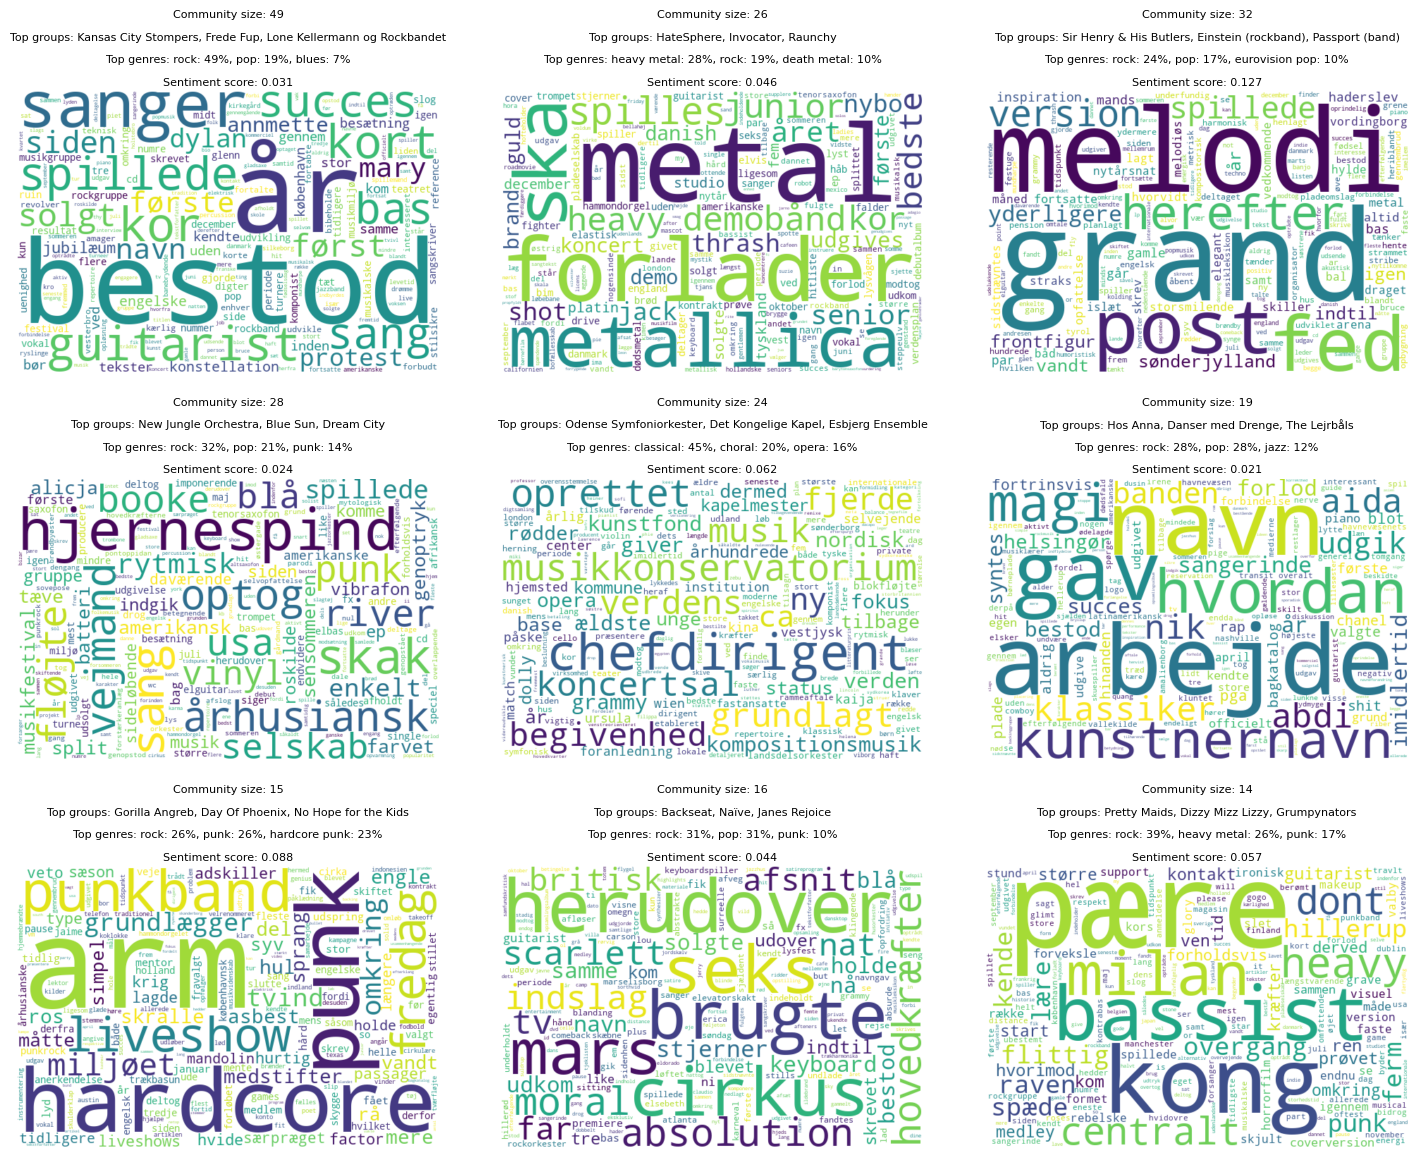

In [110]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Create a 3x3 grid of subplots

for i, (com, ax) in enumerate(zip(sorted_communities[:9], axes.flatten())):
    words = com_words[com]  # Getting the wordlist for the given community
    TF = Counter(words)  # Creating dictionary of counts
    TF_IDF = Counter({word: TF[word] * IDF_dict[word] for word in words})
    
    # Create a word cloud
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(TF_IDF)
    
    # Plot text
    fontsize = 8
    ax.text(0.5, 1.27, f"Community size: {len(communities['groups'][com])}", fontsize=fontsize , ha='center', va='center', transform=ax.transAxes)
    top_groups = sorted({group: dict_degree[group] for group in communities["groups"][com]}.items(), key = lambda x: x[1], reverse = True)
    ax.text(0.5, 1.19, "Top groups: " + ', '.join([x[0] for x in top_groups[:3]]), fontsize=fontsize , ha='center', va='center', transform=ax.transAxes)
    genretext = "Top genres: " + ', '.join(f"{genre}: {int(score * 100)}%" for genre, score in list(communities['genrecount'][com].items())[:3])
    ax.text(0.5, 1.11, genretext, fontsize=fontsize , ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 1.03, f"Sentiment score: {round(communities['scores'][com],3)}", fontsize=fontsize , ha='center', va='center', transform=ax.transAxes)
    
    # Display the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")  # Hide axes

# Show all plots in a single figure
plt.tight_layout()
plt.show()

### Musicians

In [111]:
# Get the largest connected component
largest_cc_M = max(nx.connected_components(MusiciansG), key=len)

# Create a subgraph of the largest component
G_largest_M = MusiciansG.subgraph(largest_cc_M).copy()

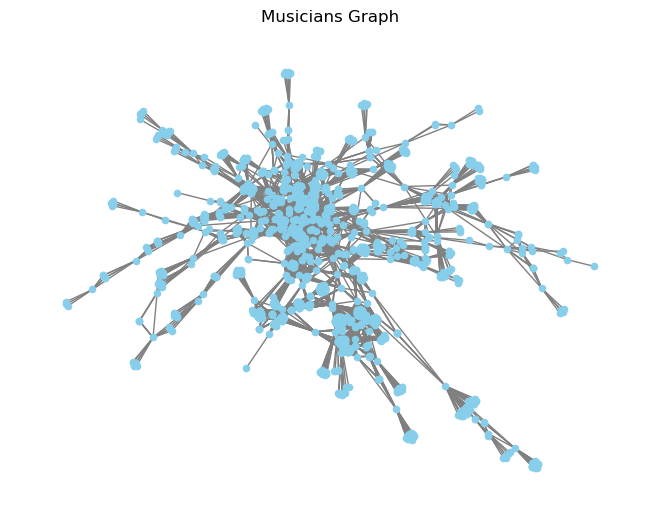

In [112]:
nx.draw(G_largest_M, with_labels=False, node_color='skyblue', node_size=20, edge_color='gray')
plt.title("Musicians Graph")
plt.show()